## 1. 얼굴 사진 준비

### 디렉토리 구조 만들기
mkdir -p ~/aiffel/camera_sticker/models   
mkdir -p ~/aiffel/camera_sticker/images

### 스티커 저장 및 디렉토리 이동
wget https://aiffelstaticprd.blob.core.windows.net/media/original_images/king.png   
wget https://aiffelstaticprd.blob.core.windows.net/media/original_images/hero.png   
mv king.png hero.png ~/aiffel/camera_sticker/images

In [560]:
# 이미지 처리를 위해 opencv 와 노트북에 이미지를 출력하기 위한 matplotlib를 읽어오기
import cv2
import matplotlib.pyplot as plt
import numpy as np

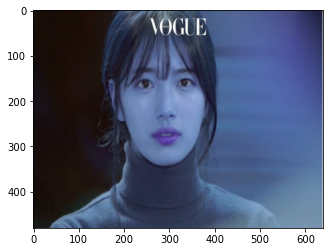

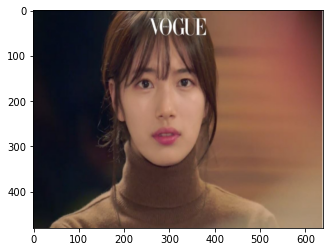

In [561]:
# 이미지 읽어와서 resize후 저장
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/face.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

# opencv는 bgr 순이라 rgb로 변경 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# flag 값은 순서대로 1, 0, -1의 값을 갖습니다. 
#cv2.IMREAD_COLOR : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시되며, Default값입니다.
#cv2.IMREAD_GRAYSCALE : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.
#cv2.IMREAD_UNCHANGED : 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.

## 2.dilb을 이용해 얼굴 검출

In [562]:
# dilb으로 dlib을 활용해 hog detector를 선언
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

In [563]:
# detector를 이용해서 얼굴의 bounding box를 추출
# dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(201, 118) (386, 304)]]


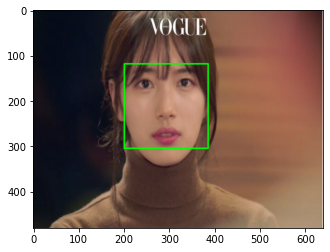

In [564]:
# bounding box로 얼굴 좌표를 찾은 후 출력
# dlib.rectangle객체는 left(), top(), right(), bottom(), height(), width()로 이루어짐
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 3. 얼굴 랜드마크   
Dlib의 ibug 300-W 데이터셋으로 학습한 pretrained model 사용   

$ wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

$ mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models  

$ cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2


In [565]:
# 모델 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크 이미지 리스트 집어넣기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


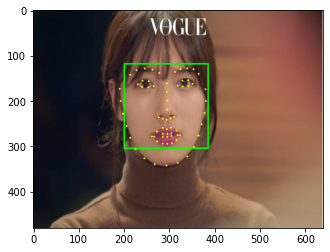

In [566]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 4. 스티커 적용하기

In [567]:
# 얼굴의 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(296, 219)
(x,y) : (296,126)
(w,h) : (186,186)


In [568]:
# 스티커를 좌표 사이즈에 맞게 리사이즈
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(186, 186, 3)


In [569]:
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (203,-60)


In [570]:
# opencv 데이터는 numpy ndarray 형태의 데이터를 사용하기때문에 ndarray는 음수 인덱스에 접근할 수 없어 음수에 대한 예외 처리해줘야함
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(126, 186, 3)


In [571]:
# 음수값을 갖던 윗부분을 제거
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (203,0)


In [572]:
# 원본 이미지에 스티커를 적용
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

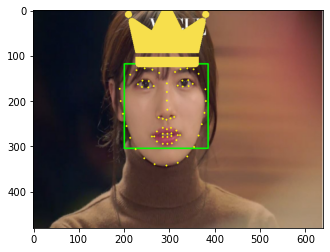

In [573]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

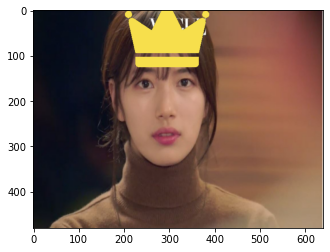

In [574]:
# bounding box와 landmark를 제거
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 다른 스티커 붙여보기

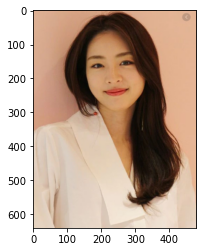

In [528]:
# 이미지 읽어와서 resize후 저장
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/yh.png'
img_bgr = cv2.imread(my_image_path) #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)

# opencv는 bgr 순이라 rgb로 변경 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

rectangles[[(139, 118) (324, 304)]]
68


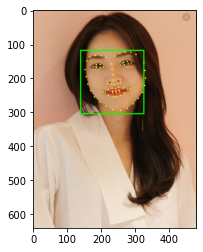

In [529]:
# dilb으로 dlib을 활용해 hog detector를 선언
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

# detector를 이용해서 얼굴의 bounding box를 추출
# dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)


# bounding box로 얼굴 좌표를 찾은 후 출력
# dlib.rectangle객체는 left(), top(), right(), bottom(), height(), width()로 이루어짐
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
#plt.show()

# 모델 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크 이미지 리스트 집어넣기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [530]:
# 얼굴의 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width() 
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(235, 205)
(x,y) : (235,112)
(w,h) : (186,186)


In [531]:
# 스티커를 좌표 사이즈에 맞게 리사이즈
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

refined_x = x - w // 2  # left
refined_y = y + h//15 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))



(186, 186, 3)
(x,y) : (142,124)


In [532]:
# 원본 이미지에 스티커를 적용
# 
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

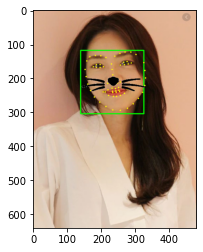

In [533]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

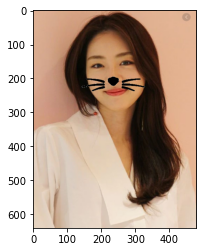

In [534]:
# bounding box와 landmark를 제거
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 정리
1. opencv는 bgr 순으로 읽어오기때문에 rgb로 변경 필수
2. landmark 30이 정중앙이어서 해결 가능했으나 좌표 4가지를 이용한 평균값을 도출하여 볼을 기준으로 하는 법 생각필요
3. 생각보다 정면 샷이 아닌 측면이나 얼굴이 비율 상 적을 경우 픽셀을 제대로 인지하지 못함. 해상도를 높이는 것도 한 방법
4. img_sticker값에서 흰색 배경값을 제거하기위해 ==255라는 RGB값과 비교함 
5. 스티커 회전? 은 추후 다시 해볼 것